<H1> Market-Cap vs Factor-weighted Indices

Indices that are market-cap weighted may fail to capture other aspects of a stock such as momentum or value
in the weighting process. While certain methodologies place a cap on weights, factor-weighted indices may
provide a more holistic weighting process.

This project aims to compare the performance of market-cap weighted vs factor weighted indices by using FTSE STI Index. For a testing period of 1-Jan-2019 to 31-Jul-2020.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import scipy.stats as stats

<h2> Part 1: Create a benchmark pseudo-STI Index

Although the STI calculation methodology is openly available, it is ratheer difficult to replicate the exact index calculated values due to limited data. Hence Part 1 first sets out to create a benchmark pseudo-STI.

Input All constituents from the period "2019-01-01" to "2020-07-31" and Obtain the total number of shares oustanding which is assumed to be relatively unchanged (negligible change).

<h3> Part 1a: Get shares oustanding

In [2]:
# Get total shares oustanding in Billions
constituents = pd.DataFrame(['C61U.SI','BN4.SI','C38U.SI','S68.SI','V03.SI',
                    'BS6.SI','N2IU.SI','C07.SI','A17U.SI','D05.SI','C31.SI',
                    'U11.SI','U14.SI','C09.SI','G13.SI','F34.SI','S63.SI','O39.SI',
                    'C52.SI','M44U.SI','U96.SI','Y92.SI','Z74.SI','C6L.SI','S58.SI',
                    'H78.SI','D01.SI','J36.SI','J37.SI','ME8U.SI','NS8U.SI','E5H.SI','T39.SI'], columns = ['Constituent'])

# Get get closest weekday day 
if (datetime.today().weekday() >= 5):
    start = datetime.today() - timedelta(days = (datetime.today().weekday()%4) ) 
else:
    start = datetime.today()
    


constituents['sharesOustanding'] = ""
for i in range(len(constituents)):
        marketCap = yf.Ticker(constituents.loc[i,'Constituent']).info.get('marketCap')
        price = float(yf.download(constituents.loc[i,'Constituent'],start = start.strftime("%Y-%m-%d"), end = datetime.today() + timedelta(days=1))['Close'].values)
        constituents.loc[i,'sharesOustanding'] = marketCap/price

constituents.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Constituent,sharesOustanding
0,C61U.SI,3.86188e+09
1,BN4.SI,1.82052e+09
2,C38U.SI,3.69015e+09
3,S68.SI,1.06898e+09
4,V03.SI,2.89265e+08


<h3> Part 1b: Recreate constituent changes

For the test date of '2019-01-01' to '2020-07-31', there were  6 quarterly reviews with 3 changes to the constituents:

1. MapleTree Commercial Trust (N2IU.SI) replaced Hutchison Port Holdings Trust (NS8U.SI), effected on '2019-09-23'
2. MapleTree Logistics Trust (M44U.SI) replaced Golden Agri-Resources (E5H.SI), effected on '2019-12-23'
3. MapleTree Industrial Trust (ME8U.SI) replaced Singapore Press Holdings (T39.SI), effected on '2020-06-22'

In [5]:
df

,effectiveDate,Constituent,Prices
0,2020-06-22,C61U.SI,1.73
1,2020-06-22,BN4.SI,6.04
2,2020-06-22,C38U.SI,2
3,2020-06-22,S68.SI,
4,2020-06-22,V03.SI,
...,...,...,...
175,2019-03-19,H78.SI,
176,2019-03-19,D01.SI,
177,2019-03-19,J36.SI,
178,2019-03-19,J37.SI,


In [6]:
df = pd.DataFrame(['2019-03-19', '2019-06-24', '2019-09-23', '2019-12-23', '2020-03-23', '2020-06-22'], columns = ['effectiveDate'])
df = df.append([df]*29)
df = df.sort_values(['effectiveDate'], ascending = 0).reset_index(drop = True)

# Recreate Constituent list taking into account constituent changes
df['Constituent'] = "" 

# filter out the latest constituents 
temp = pd.DataFrame(constituents['Constituent'])
temp = temp[(temp['Constituent'] != 'NS8U.SI') & (temp['Constituent'] != 'E5H.SI') & (temp['Constituent'] != 'T39.SI')]

for i in range(len(df)):
    if df.iloc[i,0] == '2020-06-22':
        df.iloc[i,1] = temp.iloc[i,0]
    if (df.iloc[i,0] == '2020-03-23' or df.iloc[i,0] == '2019-12-23') :
        temp.loc[temp['Constituent'] =='ME8U.SI','Constituent'] = 'T39.SI'
        df.iloc[i,1] = temp.iloc[i%30,0]
    if df.iloc[i,0] == '2019-09-23':
        temp.loc[temp['Constituent'] =='M44U.SI','Constituent'] = 'E5H.SI'
        df.iloc[i,1] = temp.iloc[i%30,0]
    if df.iloc[i,0] <= '2019-06-24':
        temp.loc[temp['Constituent'] =='N2IU.SI','Constituent'] = 'NS8U.SI'
        df.iloc[i,1] = temp.iloc[i%30,0]        

df['Prices'] = ""
# Add Price to the dataframe
for i in range(len(df)):
    df.iloc[i,2] = float(yf.download(df.iloc[i,1], start = df.iloc[0,0],end = datetime.strptime(df.iloc[0,0],'%Y-%m-%d') + timedelta(days=1), prepost = True)['Close'].values)

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,effectiveDate,Constituent,Prices
0,2020-06-22,C61U.SI,1.73
1,2020-06-22,BN4.SI,6.04
2,2020-06-22,C38U.SI,2
3,2020-06-22,S68.SI,8.12
4,2020-06-22,V03.SI,16.08


<h3> Part 1c: Calculate weights at each effective date

In [7]:
df = pd.merge(df, constituents, on=['Constituent']).sort_values(['effectiveDate'], ascending = 0).reset_index(drop = True)

# Calculate weights
df['Weight'] = ""
for i in range(len(df)):
    total_mc = sum(df[df['effectiveDate'] == df.loc[i,'effectiveDate']]['sharesOustanding']*df[df['effectiveDate'] == df.loc[i,'effectiveDate']]['Prices'])
    df.loc[i,'Weight'] = df.loc[i,'Prices']*df.loc[i,'sharesOustanding']/total_mc

df = df.set_index('effectiveDate')
df.index = pd.to_datetime(df.index)
df.head()

,Constituent,Prices,sharesOustanding,Weight
effectiveDate,,,,
2020-06-22,C61U.SI,1.73,3.86188e+09,0.0147288
2020-06-22,S68.SI,8.12,1.06898e+09,0.0191358
2020-06-22,H78.SI,4.19,2.3339e+09,0.0215585
2020-06-22,C31.SI,2.91,5.05254e+09,0.0324134
2020-06-22,V03.SI,16.08,2.89265e+08,0.0102543


<h3> Part 1d: Get raw stock data of all constituents to use as inputs for index calculation

In [8]:
# Get Data for stocks
raw_data = yf.download(list(constituents['Constituent']), start="2018-01-01", end="2020-07-31", group_by = 'ticker')


# Prepare empty dataframe to store close prices
data = pd.DataFrame(pd.date_range("2018-01-01", "2020-07-31").tolist(), columns = ['Date'])
data = data.set_index('Date')

for constituent in constituents['Constituent']:
    temp = pd.DataFrame(raw_data[(constituent,'Close')]).reset_index()
    temp.columns = ['Date', constituent]
    temp = temp.set_index('Date')
    data = data.join(temp)
    
# forward fill prices for weekends
data = data.ffill(axis = 0)
data.head()

[*********************100%***********************]  33 of 33 completed


,C61U.SI,BN4.SI,C38U.SI,S68.SI,V03.SI,BS6.SI,N2IU.SI,C07.SI,A17U.SI,D05.SI,...,C6L.SI,S58.SI,H78.SI,D01.SI,J36.SI,J37.SI,ME8U.SI,NS8U.SI,E5H.SI,T39.SI
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,1.98,7.53,2.15,7.47,21.420000,1.51,1.64357,40.880001,2.69043,25.200001,...,10.67,5.25,7.06,7.93,60.820000,39.380001,2.05,0.410,0.375,2.76
2018-01-03,1.99,7.67,2.12,7.50,22.090000,1.52,1.66349,40.939999,2.68064,25.879999,...,10.70,5.30,7.08,7.90,60.799999,39.439999,2.06,0.415,0.380,2.78
2018-01-04,2.03,7.80,2.11,7.57,21.969999,1.53,1.66349,41.279999,2.72956,26.500000,...,10.74,5.50,7.10,7.89,60.279999,39.939999,2.07,0.415,0.390,2.78
2018-01-05,1.98,7.77,2.10,7.57,21.700001,1.51,1.66349,40.980000,2.73935,26.320000,...,10.79,5.45,7.14,8.05,60.080002,39.740002,2.09,0.415,0.380,2.74


<h3> Part 1e: Calculate pseudo-STI Index Values

In [9]:
df_IV = pd.DataFrame(pd.date_range("2019-01-02", "2020-07-31").tolist(), columns = ['Date'])
df_IV = df_IV.set_index('Date')

def calculate_IV(date,df,data):
    total = 0
    
    if date <= min(df.index): #assume starting weights equals to the earliest effective date available
        for constituent in df.loc[min(df.index),'Constituent']:
            total += df[df['Constituent'] == constituent].loc[min(df.index),'Weight'] * data.loc[(date + timedelta(days=-1)).strftime("%Y-%m-%d"),constituent]         
    
    elif date < max(df.index):
        for constituent in df.loc[min(df[df.index >= date].index),'Constituent']:
            total += df[df['Constituent'] == constituent].loc[min(df[df.index >= date].index),'Weight'] * data.loc[(date + timedelta(days=-1)).strftime("%Y-%m-%d"),constituent]
    else:      
        for constituent in df.loc[max(df.index),'Constituent']:
            total += df[df['Constituent'] == constituent].loc[max(df.index),'Weight'] * data.loc[(date + timedelta(days=-1)).strftime("%Y-%m-%d"),constituent] 
    return total

df_IV['IV'] = ""
for date in df_IV.index:
    df_IV.loc[date,'IV'] = calculate_IV(date,df,data)
    
df_IV.head()

,IV
Date,
2019-01-02,17.144
2019-01-03,16.9342
2019-01-04,16.7793
2019-01-05,17.0827
2019-01-06,17.0827


<h3> Part 1f: Compare performance of pseudo-STI and STI

[*********************100%***********************]  1 of 1 completed
******************************
CAGR: -10.97%
Volatility: 1.02%
Average Daily Returns: -0.03%
Annualized Returns: -9.24%
******************************
CAGR: -22.18%
Volatility: 1.15%
Average Daily Returns: -0.06%
Annualized Returns: -20.24%


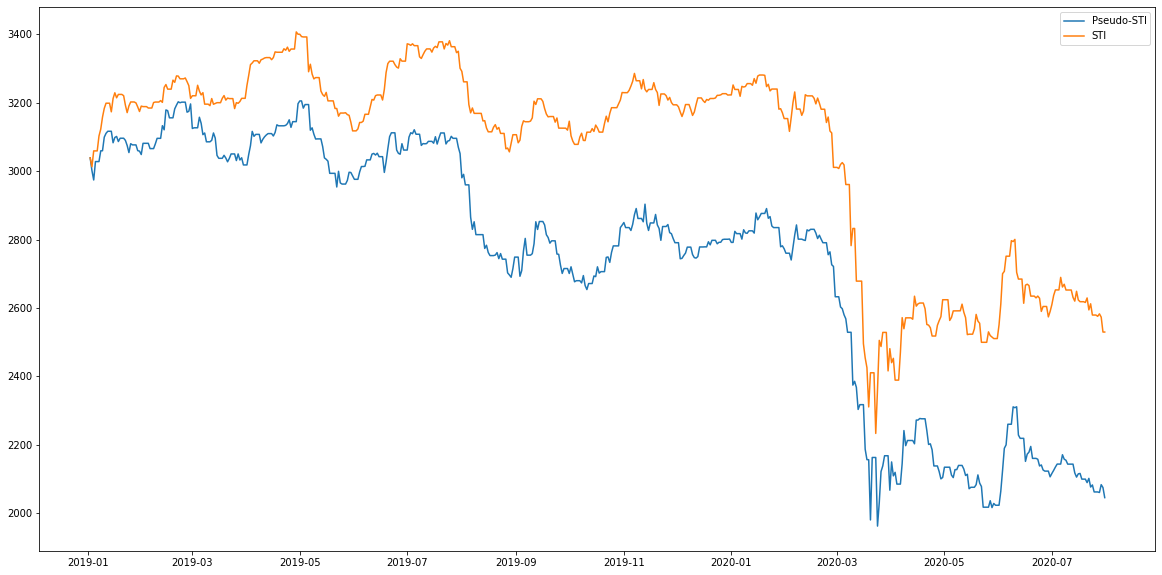

In [10]:
# Get STI for stocks for comparison
sti = pd.DataFrame(yf.download('^sti', start="2019-01-02", end="2020-07-31", group_by = 'ticker')['Close'], columns = ['Close'])
sti.columns = ['STI']

df_IV['Rebased'] = ""
df_IV['Rebased'] = df_IV.loc[:,'IV']/df_IV.loc["2019-01-02",'IV']*sti.loc["2019-01-02","STI"]

df_IV = df_IV.join(sti)
df_IV = df_IV.ffill(axis = 0)

plt.figure(figsize=(20,10)) 
plt.plot(df_IV['Rebased'], label = 'Pseudo-STI')
plt.plot(df_IV['STI'], label = 'STI')
plt.legend()

def performance(values):
    print("*"*30)
    delta = (max(values.index) - min(values.index)).days/365
    print("CAGR: " + str(round((pow(values[max(values.index)]/values[min(values.index)],1/delta)-1)*100,2)) + "%")
    print("Volatility: " + str(round(np.std(np.array((values/values.shift(1))-1)[1:])*100,2)) + "%")
    print("Average Daily Returns: " + str(round(np.mean(np.array((values/values.shift(1))-1)[1:])*100,2)) + "%")
    print("Annualized Returns: " + str(round((pow(np.mean(np.array((values/values.shift(1))-1)[1:])+1,365)-1)*100,2)) + "%")
    
performance(df_IV['STI']) 
performance(df_IV['Rebased'])

What we can observe is that the Pseudo-STI index generally follows a the same pattern as the STI but perhaps due
to differences in input values such as free-float Market Cap, index values of the Psuedo-STI are generally lower

<h1> Part 2: Implement a momentum weighted index

I used MSCI's momentum index methology (https://www.msci.com/msci-factor-indexes) to assign weights accordingly

<h2> Part 2a: Get Stock data

In [11]:
# Get a longer historical Data for stocks
raw_data = yf.download(list(constituents['Constituent']), start="2017-01-01", end="2020-07-31", group_by = 'ticker')


# Prepare empty dataframe to store close prices
data = pd.DataFrame(pd.date_range("2017-01-01", "2020-07-31").tolist(), columns = ['Date'])
data = data.set_index('Date')

for constituent in constituents['Constituent']:
    temp = pd.DataFrame(raw_data[(constituent,'Close')]).reset_index()
    temp.columns = ['Date', constituent]
    temp = temp.set_index('Date')
    data = data.join(temp)
    
# forward fill prices for weekends
data = data.ffill(axis = 0)
data.head()

[*********************100%***********************]  33 of 33 completed


,C61U.SI,BN4.SI,C38U.SI,S68.SI,V03.SI,BS6.SI,N2IU.SI,C07.SI,A17U.SI,D05.SI,...,C6L.SI,S58.SI,H78.SI,D01.SI,J36.SI,J37.SI,ME8U.SI,NS8U.SI,E5H.SI,T39.SI
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1.44646,5.80,1.925,7.15,9.89,0.820,1.39952,40.740002,2.26974,17.320000,...,9.70,4.91,6.51,7.21,57.119999,34.599998,1.640,0.435,0.420,3.53
2017-01-04,1.46102,5.82,1.930,7.13,10.12,0.825,1.40948,40.560001,2.25996,17.520000,...,9.73,4.91,6.52,7.25,57.500000,34.880001,1.645,0.435,0.425,3.58
2017-01-05,1.46588,5.93,1.945,7.21,9.97,0.840,1.42442,40.639999,2.27953,17.799999,...,9.75,4.86,6.61,7.31,59.099998,36.299999,1.650,0.430,0.420,3.60


<h2> Part 2b: Calculate momentum Score

In [12]:
def momentumScore(df,date):
    
    three_month_momentum = (df.loc[datetime.strptime(str(date.date()),'%Y-%m-%d') + relativedelta(months = -1)]/df.loc[datetime.strptime(str(date.date()),'%Y-%m-%d') + relativedelta(months = -4)])-1  

    # Approximate a three-mon return by using 90 days window
    mean = np.mean(np.array((df/df.shift(90)-1).dropna()))
    sigma = np.std(np.array((df/df.shift(90)-1).dropna()))
    
    score  = (three_month_momentum-mean)/sigma
    

    # winsorized +/- 3
    if score > 3:
        score = 3
    elif score <-3:
        score = -3
        
    if score > 0:
        return (1 + score)
    else:
        return pow((1 - score),-1)

MomentumScore = np.array([])
for date in df.index.unique():
    for i in range(30):
        MomentumScore = np.append(MomentumScore,momentumScore(data[data.index <= date][df.loc[date,'Constituent'][i]],date))

df = df.reset_index(drop = False)
df = df.join(pd.DataFrame(MomentumScore, columns = ['MomentumScore']))
df = df.set_index('effectiveDate')        
df.head()

,Constituent,Prices,sharesOustanding,Weight,MomentumScore
effectiveDate,,,,,
2020-06-22,C61U.SI,1.73,3.86188e+09,0.0147288,0.306720
2020-06-22,S68.SI,8.12,1.06898e+09,0.0191358,2.333135
2020-06-22,H78.SI,4.19,2.3339e+09,0.0215585,0.260220
2020-06-22,C31.SI,2.91,5.05254e+09,0.0324134,0.291080
2020-06-22,V03.SI,16.08,2.89265e+08,0.0102543,0.589444


<h2> Part 2c: Calculate Weights based on momentum Score

In [13]:
df['Weight_Momentum'] = df['Weight']*df['MomentumScore']

# Normalize weights to 100%
Weight_Momentum_Norm = np.array([])
for date in df.index.unique():
    Weight_Momentum_Norm = np.append(Weight_Momentum_Norm,df.loc[date]['Weight_Momentum']/sum(df.loc[date,'Weight_Momentum']))

df = df.reset_index(drop = False)
df = df.join(pd.DataFrame(Weight_Momentum_Norm, columns = ['Weight_Momentum_Norm']))
df = df.set_index('effectiveDate')        
df.head()

,Constituent,Prices,sharesOustanding,Weight,MomentumScore,Weight_Momentum,Weight_Momentum_Norm
effectiveDate,,,,,,,
2020-06-22,C61U.SI,1.73,3.86188e+09,0.0147288,0.306720,0.00451761,0.012403
2020-06-22,S68.SI,8.12,1.06898e+09,0.0191358,2.333135,0.0446465,0.122576
2020-06-22,H78.SI,4.19,2.3339e+09,0.0215585,0.260220,0.00560995,0.015402
2020-06-22,C31.SI,2.91,5.05254e+09,0.0324134,0.291080,0.00943491,0.0259033
2020-06-22,V03.SI,16.08,2.89265e+08,0.0102543,0.589444,0.0060443,0.0165945


<h2> Part 2d: Calculate Index Value

In [14]:
def calculate_IV(date,df,data):
    total = 0
    
    if date <= min(df.index): #assume starting weights equals to the earliest effective date available
        for constituent in df.loc[min(df.index),'Constituent']:
            total += df[df['Constituent'] == constituent].loc[min(df.index),'Weight_Momentum_Norm'] * data.loc[(date + timedelta(days=-1)).strftime("%Y-%m-%d"),constituent]         
        
    if date < max(df.index):
        for constituent in df.loc[min(df[df.index >= date].index),'Constituent']:
            total += df[df['Constituent'] == constituent].loc[min(df[df.index >= date].index),'Weight_Momentum_Norm'] * data.loc[(date + timedelta(days=-1)).strftime("%Y-%m-%d"),constituent]
    else:      
        for constituent in df.loc[max(df.index),'Constituent']:
            total += df[df['Constituent'] == constituent].loc[max(df.index),'Weight_Momentum_Norm'] * data.loc[(date + timedelta(days=-1)).strftime("%Y-%m-%d"),constituent] 
    return total

df_IV['IV_Momentum'] = ""
for date in df_IV.index:
    df_IV.loc[date,'IV_Momentum'] = calculate_IV(date,df,data)
    
df_IV.head()

,IV,Rebased,STI,IV_Momentum
Date,,,,
2019-01-02,17.143978,3038.889893,3038.889893,37.9817
2019-01-03,16.934152,3001.696730,3012.879883,37.4801
2019-01-04,16.779298,2974.247860,3059.229980,37.1517
2019-01-05,17.082723,3028.032047,3059.229980,37.879
2019-01-06,17.082723,3028.032047,3059.229980,37.879


<h2> Part 2e: Compare against Market-Cap Weighted Values

******************************
CAGR: -56.79%
Volatility: 4.77%
Average Daily Returns: -0.09%
Annualized Returns: -27.3%
******************************
CAGR: -22.18%
Volatility: 1.15%
Average Daily Returns: -0.06%
Annualized Returns: -20.24%


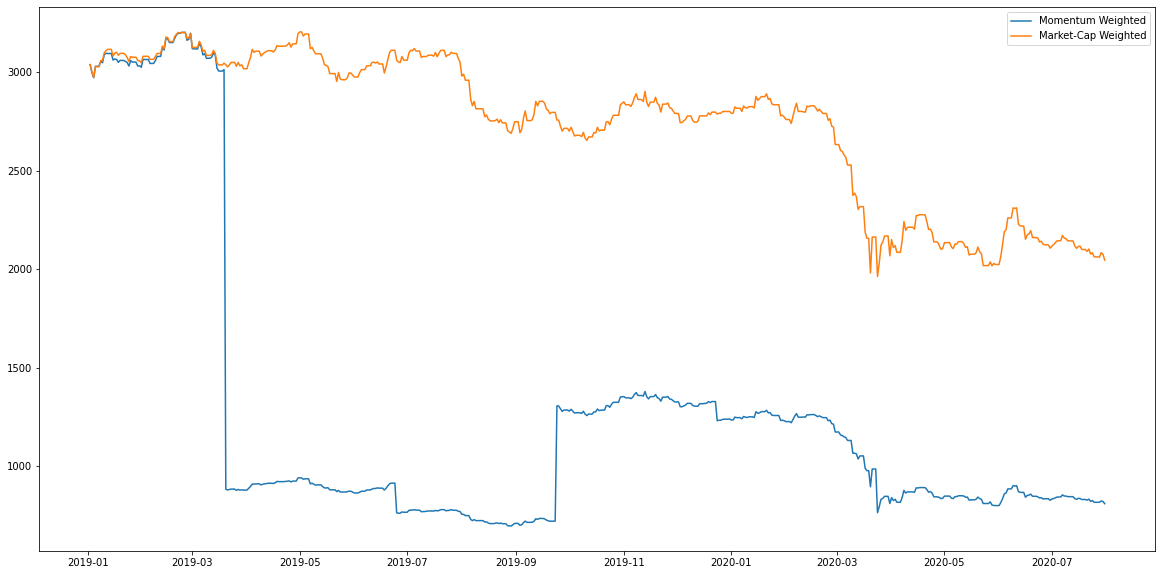

In [15]:
df_IV['IV_Momentum_Rebased'] = df_IV.loc[:,'IV_Momentum']/df_IV.loc["2019-01-02",'IV_Momentum']*sti.loc["2019-01-02","STI"]    

plt.figure(figsize=(20,10)) 
plt.plot(df_IV['IV_Momentum_Rebased'], label = 'Momentum Weighted')
plt.plot(df_IV['Rebased'], label = 'Market-Cap Weighted')
plt.legend()

performance(df_IV['IV_Momentum_Rebased']) 
performance(df_IV['Rebased'])

The momentum-weighted index performed worse-off than the market-cap weighted index. Perhaps the momentum methdology
is equally likely to ampilfy a downward sell-off as it is to amplify an upward trend.

In [16]:
# Latest effective date weight comparison
df.loc['2020-6-22', ('Constituent','Weight_Momentum_Norm','Weight')]

,Constituent,Weight_Momentum_Norm,Weight
effectiveDate,,,
2020-06-22,C61U.SI,0.012403,0.0147288
2020-06-22,S68.SI,0.122576,0.0191358
2020-06-22,H78.SI,0.015402,0.0215585
2020-06-22,C31.SI,0.0259033,0.0324134
2020-06-22,V03.SI,0.0165945,0.0102543
2020-06-22,C52.SI,0.00772666,0.00759493
2020-06-22,S58.SI,0.00539103,0.00766651
2020-06-22,BS6.SI,0.0137859,0.00837999
2020-06-22,D05.SI,0.101954,0.117828
